In [359]:
using BSON: @load
using Flux
using Flux.Optimise
using Flux.Optimise: update!
using Flux.Data: DataLoader
using ImageFiltering
using Images
using ImageIO
using MLDatasets: FashionMNIST
using LinearAlgebra
using MLDatasets
using Plots
using Zygote
using FFTW
using Distributions
using SparseArrays
using JLD

In [225]:
function sample_fourier(aimed_m, n)
    F = dct(diagm(ones(n)),2)
    sampling = rand(Bernoulli(aimed_m/n), n)
    true_m = sum(sampling)
    return (true_m, F[sampling,:])
end

sample_fourier (generic function with 1 method)

Let $A_d$ be a $n\times k$ matrix and $A$ be a $n\times n$ unitary matrix.  The incoherence of a subspace $\textit{Range}(A_d)$ with respect to the unitary matrix $A$ equals
$$ \sup_{x\in\mathcal{R}(A_d)\cap \mathcal{S}^{n-1}} \|A x\|_\infty = \max_{i \in [n]}\left\{\sup_{u\in\mathbb{R}^{k}} \langle a_i, A_d u\rangle \text{ s.t. } \|A_du\|_2 = 1 \right\}$$
where $a_i$ is the $i$-th row of $A_d$. Consider the (thin)-QR decompition of $A_d = QR$. Then,
$$\sup_{u\in\mathbb{R}^{k}} \langle a_i, A_d u\rangle \text{ s.t. } \|A_du\|_2 = 1 =  \sup_{u\in\mathbb{R}^{k}} \langle Q^\top a_i, R u\rangle \text{ s.t. } \|Ru\|_2 = 1.$$
Consider a change of variable of $u = R^{-1} v$, for some $v \in \mathbb{R}^k$. It is easy to see that this supremum value is $\|Q^\top a_i\|_2$. Thus,
$$ \sup_{x\in\mathcal{R}(A_d)\cap \mathcal{S}^{n-1}} \|A x\|_\infty = \max_{i \in [n]} \|Q^\top a_i\|_2.$$


$\sup_{x\in\mathcal{R}(A_d)\cap \mathcal{S}^{n-1}} \|A x\|_\infty$ only provides an upper bound to the incoherence of the GNN w.r.t $A$ given by
$$ \sup_{x\in\mathcal{R}(G)\cap \mathcal{S}^{n-1}}\|A x\|_\infty.$$


In [371]:
function subspace_incoherence(F, A)
    α = 0
    m, _ = size(A)
    QR_decomp = qr(A)

    for i in 1:m
        temp = norm(Matrix(QR_decomp.Q)'*F[i,:], 2)
        α = max(α, temp)
    end
    return α
end



subspace_incoherence (generic function with 1 method)

In [372]:

function relative_error(z₀, z_est)
    return(norm(z₀ - z_est, 2)/ norm(z₀, 2))
end  

function load_model(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder
    println("Done")
    return encoder_μ, encoder_logvar, decoder
end

load_model (generic function with 1 method)

Consider the compressed sensing problem of recovering $x\in\mathbb{R}^n$ from noisy measurements of the form

$$y = A x_{0} + \epsilon, $$

where $\epsilon\in\mathbb{R}^n$ is noise and $A$ is the compressive sensing matrix. We assume the unknown signal $x$ lives in the range of known generative model $G:\mathbb{R}^k \rightarrow \mathbb{R}^n$, i.e. $x_{0} = G(z_0)$ for some $z_0 \in \mathbb{R}^k$. We assume the generative model $G$ is  fully-connected feedforward network of the form 

$$ G(x) = A_d\sigma(A_{d-1} \cdots \sigma(A_1 z)\cdots),$$

where $A_i \in \mathbb{R}^{n_i \times n_{i-1}}$ is the weight matrix and $\sigma(\cdot)$ is the activation function. We
determine the conditions (on $A, G, x_{0}$, \etc) under which it is possible to (approximately) recover $x_{0}$ from noisy linear measurements $y$ by (approximately) solving an optimization problem of the form

$$\argmin_{z \in \mathbb{R}^{k}} \|b - A G(z) \|_{2}. $$

Although this optimzation problem is non-convex, it has been shown that gradient descent and other descent-type alogorithm can provably converge to the global optima. 

In [569]:
function estimated_code(opt, G, y, A, init; max_iter, tolerance, out_toggle = 0)
    z_est = init
    θ = Flux.params(z_est)
    iter = 1
    ∇f = 1.0
    while ∇f >= tolerance && iter <= max_iter
        grads = gradient(() -> loss(z_est, y, G, F_sub), θ)
        update!(opt, z_est, grads[z_est])
        ∇f = norm(grads[z_est], 2)
        iter += 1
        if out_toggle != 0 && iter % out_toggle == 0
            println("====> In Gradient: Iteration: $iter gradient norm: $∇f")
        end
    end
    return z_est
end



estimated_code (generic function with 1 method)

In the next experiment, we consider a one hidden layer network of the form $G(z) = A_2σ(A_1z)$. The inner layer matrix $A_1 \in \mathbb{R}^{n_1\times k}$ has $\mathcal{N}(0,1/n_1)$ entries. For the outer layer matrix $A_2 \in \mathbb{R}^{n_2\times n_1}$ ($n_2 = n$), we take a matrix $A_{21}$ which contains columns randomly subsampled (without replacement) from a $n\times n$ DCT matrix and a random matrix $A_{22}$ which contains $\mathcal{N}(0,1/n_2)$ entries and take its convex combination, i.e. 
$$A_2 = \beta A_{21} + (1-\beta) A_{22}$$
for $\beta \in [0,1]$.

For each $\beta \in [0.7,1]$, we attempt to recover the code vector $z_0$ from measurement of the form $y = A G(z_0)$ where $A \in \mathbb{R}^{m\times n}$ is subsampled DCT matrix (without replacement) by solve the least squares optimzation problem using the gradient descent algorithm. We show the results from 20 trials for each $\beta$ and for all trials, $z_0, A_1, A_{21}$, and $A_{22}$ are fixed. For all experiments, $k = 20, n = 400$, $n_1$ is approximately 100, and $m$ is approximately 160.

In [565]:
#setup a synthetic problem
k = 20
aimed_n1 = 100
x_dim = 400
aimed_m = 200

n1, A = sample_fourier(aimed_n1, x_dim); A = A' #sub-sampled DCT matrix used in convex combination
B = randn(x_dim, n1)/sqrt(x_dim) #random matrix that is used in convex combination
W1 = randn(n1, 20)/sqrt(n1) #random inner layer weight matrix
I(x) = x

tolerance = 1e-7; max_iter = 2000; out_toggle = 0

z = randn(k) # ground code vector

β_list = 0:.1:1
trials = 20
recovery_error_matrix = zeros(trials)
recon_error_matrix = zeros(trials)

α_list = []
F = dct(diagm(ones(x_dim)),2)
for β in β_list
    push!(α_list, subspace_incoherence(F, β*A + (1-β) * B) )
end

opt = Flux.Optimise.ADAM(.1) # optimizer
for β in β_list
    recovery_error_list = []
    recon_error_list = []
    G = Chain(
        Dense(20, n1, relu, bias = false; init =(out,in) -> W1),
        Dense(n1, x_dim, I, bias = false; init =(out,in) -> β*A + (1-β) * B)
    )    #setup the generative network 


    for trials in 1:trials
        m, F_sub = sample_fourier(aimed_m, x_dim)  # subsampling DCT for measurement matrix
        F_sub = F_sub * sqrt(x_dim)/sqrt(m) #normalization          
        y = F_sub * G(z) # measurement vector using subsampled DCT matrix
        z_est = randn(k) #initialization for algorithm
        z_est = estimated_code(opt, G, y, F_sub, z_est; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
        push!(recovery_error_list, relative_error(z, z_est))    
        push!(recon_error_list, relative_error(G(z), G(z_est)))
    end

    recovery_error_matrix =  hcat(recovery_error_matrix, recovery_error_list)
    recon_error_matrix = hcat(recon_error_matrix, recon_error_list)
end



====> In Gradient: Iteration: 2001 gradient norm: 1.222845385766022e-7


====> In Gradient: Iteration: 2001 gradient norm: 1.2915385337769898e-5


====> In Gradient: Iteration: 2001 gradient norm: 2.9971126394802483e-5


====> In Gradient: Iteration: 2001 gradient norm: 2.670277205338923e-5


====> In Gradient: Iteration: 2001 gradient norm: 3.451002172817211e-7


====> In Gradient: Iteration: 2001 gradient norm: 2.198142793969677e-5


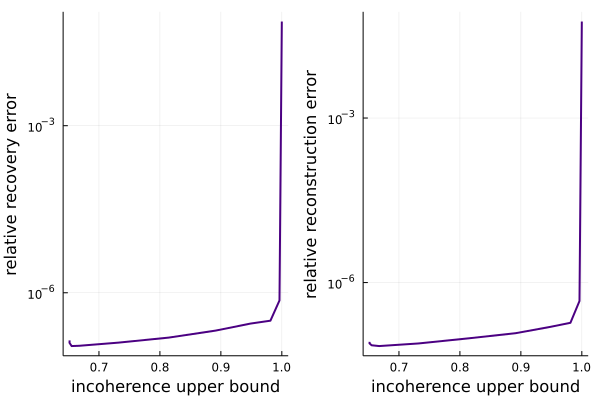

In [566]:
cs = palette([:red,  :orange, :green, :blue, :Indigo], 1000)

average_recov = mean(recovery_error_matrix[:, 2:end], dims=1)'
# std_recov = std(recovery_error_matrix[:, 2:end], dims=1)'
# plot(α_list, average_recov + std_recov, fillrange = max.(0, average_recov - std_recov), fillalpha = .2, c = cs[400], label = false,linecolor = invisible())
p1 = plot(α_list, average_recov, xlabel = "incoherence upper bound", ylabel = "relative recovery error", linewidth = 2, color = cs[1000], label =false, yaxis =:log )


average_recon = mean(recon_error_matrix[:, 2:end], dims=1)'
# std_recon = std(recon_error_matrix[:, 2:end], dims=1)
# # plot(α_list, average_recon + std_recon, fillrange = max.(0, average_recon - std_recon), fillalpha = .2, c = cs[400], label = false, linecolor = invisible())
p2 = plot(α_list, average_recon, xlabel = "incoherence upper bound", ylabel = "relative reconstruction error", linewidth = 2, color = cs[1000], label =false, yaxis =:log  )

plot(p1,p2,layout = 2)


In [567]:
savefig("DCT/error_plot_rand.pdf")
save("DCT/error_matrix_2.jld", "recovery error", recovery_error_matrix, "reconstruction error", recon_error_matrix, "α_list", α_list)


In [573]:
# experiments with MNIST dataset
k = 20
aimed_n1 = 100
x_dim = 400
aimed_m = 200


n1, A = sample_fourier(aimed_n1, x_dim); A = A' #sub-sampled DCT matrix used in convex combination
B = randn(x_dim, n1)/sqrt(x_dim) #random matrix that is used in convex combination

epoch_to_load = 20 # Load the model and test set loader
_, _, decoder = load_model("MNIST", epoch_to_load)
W1 = Flux.params(decoder)[1][1:n1,:]
_, s, _ = svd(W1)
W1 = W1 / s[1]
I(x) = x




tolerance = 1e-7; max_iter = 2000; out_toggle = 0

z = randn(k) # ground code vector

β_list = 0:.1:1
trials = 20
recovery_error_matrix = zeros(trials)
recon_error_matrix = zeros(trials)

α_list = []
F = dct(diagm(ones(x_dim)),2)
for β in β_list
    push!(α_list, subspace_incoherence(F, β*A + (1-β) * B) )
end

opt = Flux.Optimise.ADAM(.1)

for β in β_list
    recovery_error_list = []
    recon_error_list = []
    G = Chain(
        Dense(20, n1, relu, bias = false; init =(out,in) -> W1),
        Dense(n1, x_dim, I, bias = false; init =(out,in) -> β*A + (1-β) * B)
    )    #setup the generative network 


    for trials in 1:trials
        m, F_sub = sample_fourier(aimed_m, x_dim)  # subsampling DCT for measurement matrix
        F_sub = F_sub * sqrt(x_dim)/sqrt(m) #normalization          
        y = F_sub * G(z) # measurement vector using subsampled DCT matrix
  
        z_est = randn(k) #initialization for algorithm
        z_est = estimated_code(opt, G, y, F_sub, z_est; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem

        push!(recovery_error_list, relative_error(z, z_est))    
        push!(recon_error_list, relative_error(G(z), G(z_est)))
    end

    recovery_error_matrix =  hcat(recovery_error_matrix, recovery_error_list)
    recon_error_matrix = hcat(recon_error_matrix, recon_error_list)
end




Loading model...Done


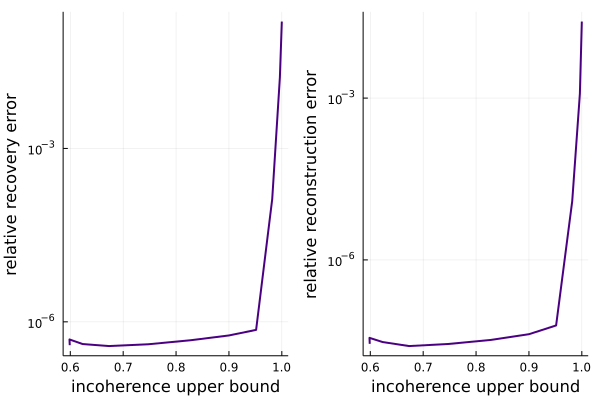

In [574]:
cs = palette([:red,  :orange, :green, :blue, :Indigo], 1000)

average_recov = mean(recovery_error_matrix[:, 2:end], dims=1)'
# std_recov = std(recovery_error_matrix[:, 2:end], dims=1)'
# plot(α_list, average_recov + std_recov, fillrange = max.(0, average_recov - std_recov), fillalpha = .2, c = cs[400], label = false,linecolor = invisible())
p1 = plot(α_list, average_recov, xlabel = "incoherence upper bound", ylabel = "relative recovery error", linewidth = 2, color = cs[1000], label =false, yaxis =:log )


average_recon = mean(recon_error_matrix[:, 2:end], dims=1)'
# std_recon = std(recon_error_matrix[:, 2:end], dims=1)
# # plot(α_list, average_recon + std_recon, fillrange = max.(0, average_recon - std_recon), fillalpha = .2, c = cs[400], label = false, linecolor = invisible())
p2 = plot(α_list, average_recon, xlabel = "incoherence upper bound", ylabel = "relative reconstruction error", linewidth = 2, color = cs[1000], label =false, yaxis =:log  )

plot(p1,p2,layout = 2)

In [576]:
savefig("DCT/error_plot_mnist.pdf")
save("DCT/error_matrix_mnist.jld", "recovery error", recovery_error_matrix, "reconstruction error", recon_error_matrix, "α_list", α_list)